In [1]:
import pandas as pd
import string as st
import matplotlib
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

### load cogsci affiliations data and preprocess

In [142]:
# load dataset as pandas df
data_file = '../data/180213_cogsci_journal_unprocessed.csv'
df_pd = pd.read_csv(data_file)

# fix the article index column name
df_pd.rename(columns={"Unnamed: 0": "Article Index"}, inplace=True)

# drop all rows where 'article_name' is nan
df_pd = df_pd.dropna(how='all', subset=['article_name'])

# need to realign indices to start at 0
df_pd.index=range(len(df_pd.index))

### subselect articles by article type (original article, commentary, etc)

In [143]:
#This function will replace all the inconsistent types of our data set with consolidated types of interest
def ConsolidateType(lst,df_pd):
    oldTypes = df_pd.article_type.values
    newTypes = []
    for i in range(len(oldTypes)):
        # NOTE: index 0 of each sublist of lst is the name of that publication type, not a filter term        
        for j in range(len(lst)):
            
            if oldTypes[i] in lst[j][1:]:                
                newTypes.append(lst[j][0])
                break
            elif j == len(lst)-1:                
                newTypes.append(np.nan)
                                
    df_pd.article_type = newTypes

In [144]:
# prune articles by subselecting only certain article types, defined by art_types
# CSV file where each row is a publication type.
# first element of every row is the name of the type
art_types = '../data/Article_Types_V1.csv'
df_art_types = pd.read_csv(art_types, sep=',', header= None)

# makes a list of lists where each sublist is an article type. elem 0 is name, rest elements
lst=[[] for _ in range(len(df_art_types))] 

#populates list with csv data
for i in range(df_art_types.shape[1]):
        for j in range(df_art_types.shape[0]):
            lst[j].append(df_art_types[i][j])
            
#removes nan from list of list (it is square by default)           
for a in range(len(lst)):
    lst[a] = [x for x in lst[a] if str(x) != 'nan']

ConsolidateType(lst,df_pd)

# removes unwanted types from our dataset
df_incl_articles = df_pd.dropna(how='any', subset=['article_type'])
df_incl_articles.index=range(len(df_incl_articles.index))

# save out 
df_incl_articles.to_csv("../data/cogsci_consolidated_types.csv")

In [146]:
# included article types
print(np.unique(df_incl_articles['article_type']))

['Announcement' 'Brief_Report' 'Comment' 'Commentary' 'Extended_Article'
 'Letter_to_Editor' 'Original_Article' 'Regular_Article' 'Special']


### making hexagon data (categorize affiliations)

In [147]:
#This function will replace all the inconsistent types of our data set with consolidated types of interest
def Consolidate_hex(aff_lst,aff_df, columns):
    # initialize empty hexacount df
    hexaCount=pd.DataFrame(0, index=np.arange(len(aff_df)), columns=columns)

    for i in range(len(aff_df)):
        # NOTE: index 0 of each sublist of lst is the name of that publication type, not a filter term
        if pd.isnull(aff_df.iloc[i]):
            # skip because it's nan
            hexaCount["missing"].iloc[i] = 1
            hexaCount["total"].iloc[i] = hexaCount.iloc[i].sum()
            continue
        
        # this loop iterates over all hexagon categories and add 1 for articles that satisfy
        for j in range(len(aff_lst)):
            for k in range(len(aff_lst[j])):                
                if aff_lst[j][k] in aff_df.iloc[i]:                    
                    hexaCount.iloc[i][aff_lst[j][0]] += 1
                    continue
        
        # append 1 to other if the row is all 0s here
        if hexaCount.iloc[i].sum()<1.:            
                hexaCount["other"].iloc[i] = 1
        
        # get the total number of satisfied hexagon categories
        hexaCount["total"].iloc[i] = hexaCount.iloc[i].sum()

    return hexaCount        

In [148]:
hex_def_file = '../data/Affiliation_types_V2.csv'

# This cell will make arrays of "hexagonal" terms from a csv file
aff_types = pd.read_csv(hex_def_file, sep=',', header=None,encoding='latin-1')

# makes a list of lists where each sublist is a hexagonal type. elem 0 is name, rest elements
aff_lst=[[] for _ in range(len(aff_types))] 

#populates list with csv data
for i in range(aff_types.shape[1]):
        for j in range(aff_types.shape[0]):
            aff_lst[j].append(aff_types[i][j])

#removes nan from list of list (it is square by default)           
for a in range(len(aff_lst)):
    aff_lst[a] = [x for x in aff_lst[a] if str(x) != 'nan']
    
# print out included types
print(aff_lst)

# make additional columns for the final table
columns = []
for cat in aff_lst:
    columns.append(cat[0])

columns.append('other')
columns.append('missing')
columns.append('total')

[['anthropology', 'anthro'], ['artificial intelligence', 'artificial intelligence', 'decision', 'machine', 'artificial intelligence'], ['linguistics', 'linguistic', 'language', 'communication', 'speech'], ['neuroscience', 'neuroscience', 'neuro', 'neural'], ['philosophy', 'philosophy'], ['psychology', 'psychology', 'psycho', 'behavior', 'psicolog\x92a'], ['computer science', 'computer science', 'cybernetics', 'computer', 'eecs', 'technology', 'cecs', 'parc', 'informatique', 'informatic', 'mit media'], ['cognitive science', 'cognitive', 'cognitiva'], ['engineering', 'engineer'], ['education', 'education'], ['biology', 'bio', 'kinesiology', 'health'], ['business', 'business', 'management', 'marketing'], ['physiology', 'physiology', 'fisiolog\x92a'], ['psychiatry', 'psychiatry'], ['music', 'music'], ['math', 'math']]


In [149]:
# Build Hexagon
hexaCount = Consolidate_hex(aff_lst, df_incl_articles["author_affiliations"].str.lower(), columns)

In [150]:
# append hexagon to original data
pd_concat = pd.concat([df_incl_articles, hexaCount], axis=1)

In [151]:
pd_concat

,article_index,article_name,year,volume,issue,pages,month,doi,article_type,authors,...,education,biology,business,physiology,psychiatry,music,math,other,missing,total
0,2,Why Cognitive Science,1977.0,1.0,1,1-2,January,10.1207/s15516709cog0101_1,Original_Article,Allan Collins,...,0,0,0,0,0,0,0,0,1,1
1,3,"An Overview of KRL, a Knowledge Representation...",1977.0,1.0,1,3-46,January,10.1207/s15516709cog0101_2,Original_Article,"Daniel G. Bobrow1,* and\nTerry Winograd2",...,0,0,0,0,0,0,0,1,0,1
2,4,Human and Computational Question Answering†,1977.0,1.0,1,47-73,January,10.1207/s15516709cog0101_3,Original_Article,Wendy Lehnert*,...,0,0,0,0,0,0,0,1,0,1
3,5,Definite Descriptions and Semantic Memory†,1977.0,1.0,1,74-83,January,10.1207/s15516709cog0101_4,Original_Article,Andrew Ortony* and\nRichard C. Anderson,...,0,0,0,0,0,0,0,1,0,1
4,6,"Artificial Intelligence, Language, and the Stu...",1977.0,1.0,1,84-123,January,10.1207/s15516709cog0101_5,Original_Article,Professor Ira Goldstein* and\nSeymour Papert,...,0,0,0,0,0,0,0,0,0,1
5,7,Induction of Augmented Transition Networks†,1977.0,1.0,2,125-157,April,10.1207/s15516709cog0102_1,Original_Article,John R. Anderson*,...,0,0,0,0,0,0,0,1,0,1
6,8,Decision Theory and Artificial Intelligence II...,1977.0,1.0,2,158-192,April,10.1207/s15516709cog0102_2,Original_Article,"Jerome A. Feldman1,* and\nRobert F. Sproull2",...,0,0,0,0,0,0,0,1,0,1
7,9,Problem Solving in Semantically Rich Domains: ...,1977.0,1.0,2,193-215,April,10.1207/s15516709cog0102_3,Original_Article,R. Bhaskar and\nHerbert A. Simon*,...,0,0,0,0,0,0,0,1,0,1
8,10,"Verbs, Time, and Modality†",1977.0,1.0,2,216-234,April,10.1207/s15516709cog0102_4,Original_Article,M. J. Steedman*,...,0,0,0,0,0,0,0,1,0,1
9,11,What Sort of Taxonomy of Causation Do We Need ...,1977.0,1.0,3,235-264,July,10.1207/s15516709cog0103_1,Original_Article,Yorick Wilks,...,0,0,0,0,0,0,0,1,0,1


### Visualization

Text(0.5,1,'Sum over all years')

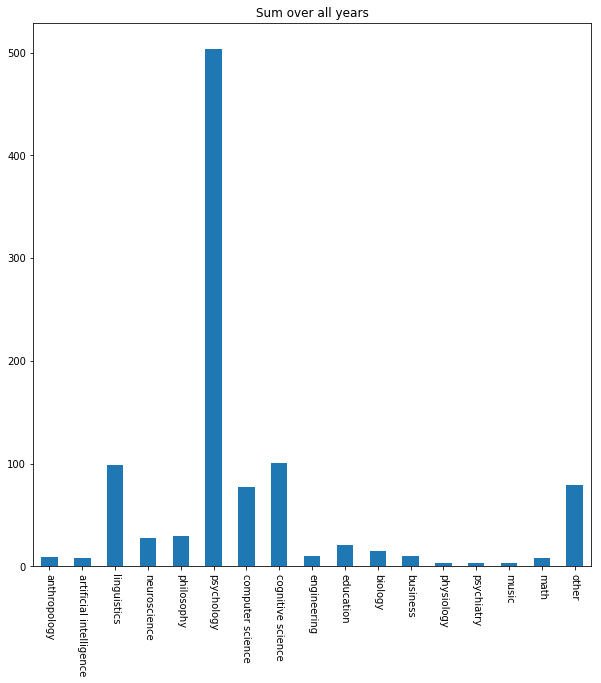

In [152]:
# histogram over all years
# plot hexagon normalized by total (0:-2 indexing to exclude columns missing and total)
years_after = 2000
hex_normed = pd_concat[pd_concat['year']>years_after][columns[:-2]].div(pd_concat[pd_concat['year']>years_after]['total'], axis='rows')
hex_normed.sum().plot(kind='bar', figsize=(10,10))
plt.xticks(rotation=270)
plt.title('Sum over all years')

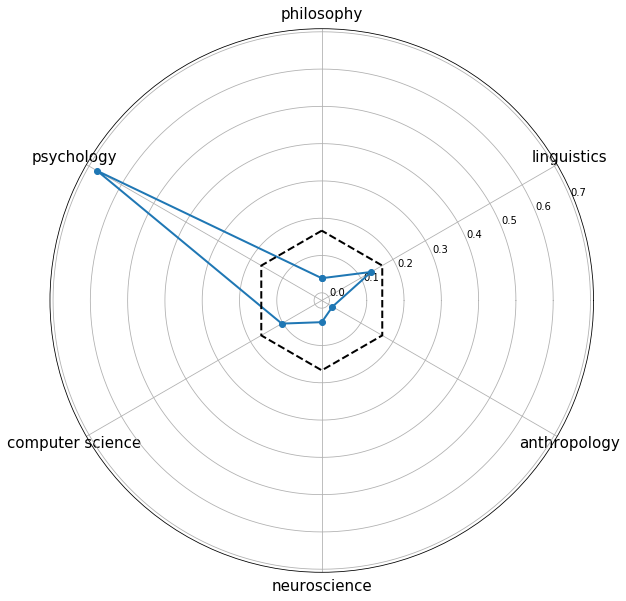

In [170]:
# columns_plot = ['anthropology', 'artificial intelligence', 'linguistics',
#        'neuroscience', 'philosophy', 'psychology', 'computer science', 'cognitive science']
columns_plot = ['philosophy', 'psychology', 'computer science', 'neuroscience','anthropology', 'linguistics']

# get the hexagon
hex_collapsed = hex_normed.sum()[columns_plot]/hex_normed.sum()[columns_plot].sum()

# create the radial points
theta = (np.linspace(0, np.pi*2-np.pi*2/len(hex_collapsed), len(hex_collapsed))+np.pi/2.)%(np.pi*2)
theta_app = np.append(theta, theta[0])
theta_app

# plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, polar=True)
ax.plot(theta_app, np.append(hex_collapsed, hex_collapsed[0]), '-o', lw=2)
# plot uniform distribution
ax.plot(theta_app, np.ones(len(theta)+1)/len(theta), 'k--',lw=2)
ax.set_xticks(theta)
ax.set_xticklabels(hex_collapsed.keys(), fontsize=15);

Text(0.5,1,'Hexagon normed, and proportion per year')

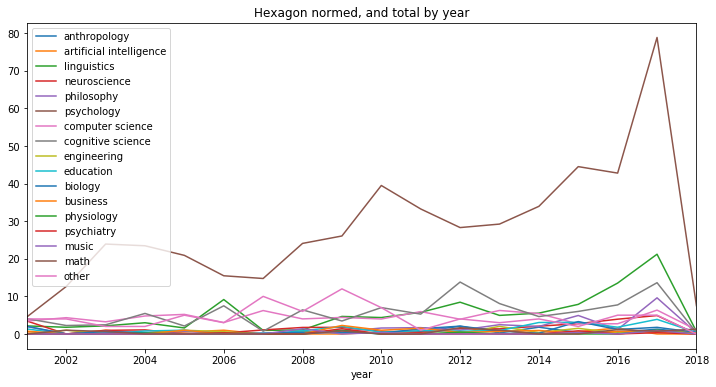

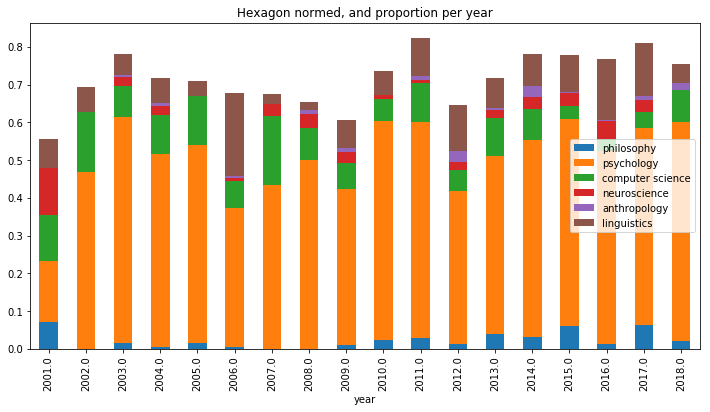

In [171]:
# this plots sum per year, which means it sums to the total # of articles written that year
#hex_normed.groupby(pd_concat['year']).sum().plot(figsize=(12,6))
hex_normed.groupby(pd_concat[pd_concat['year']>years_after]['year']).sum().plot(figsize=(12,6))
plt.title('Hexagon normed, and total by year')

# this plots mean per year, which means it normalizes by the number of articles written per year
hex_normed[columns_plot].groupby(pd_concat[pd_concat['year']>years_after]['year']).mean().plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Hexagon normed, and proportion per year')

# pd.groupby is a function that collects rows based on some criteria, in this case, the year of the article
# you guys can figure out how to groupby decades or per 5 years